## Installs and imports

In [120]:
# !apt install unzip wget -y
# !pip install -q torch==1.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
# !pip install -q -U sklearn pandas matplotlib albumentations xmltodict gdown 
# !gdown --fuzzy "https://drive.google.com/file/d/1hnmyIXI7UW37_enpfXYsr26N1zSeTncF/view?usp=sharing"
# !unzip "data.zip" -d "data"

In [1]:
import os
import glob
import time
from datetime import datetime
import xmltodict
import json

import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import torchvision
import torchvision.transforms as T

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import cv2

from sklearn.metrics import auc
import matplotlib.pyplot as plt

## Preparing data

## Preparing ETL pipeline (Dataset, transforms and collator)

In [2]:
class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None, class2tag=None):
        self.images = []
        self.annotations = []
        self.transform = transform

        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            
            img_mod = cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB).astype(np.float32)
            img_mod /= 255.0
            
            self.images.append(img_mod)

            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())

            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]

            if not isinstance(objects, list):
                objects = [objects]

            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))

                if class2tag is not None:
                    labels.append(class2tag[obj["name"]])
                else:
                    labels.append(1)

            self.annotations.append({"boxes": torch.stack(bboxes).float(), 
                                     "labels": torch.tensor(labels)})

    def __getitem__(self, i):
        if self.transform:
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"]
                )
            
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"])
                }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

In [3]:
def get_transforms(train=False):
    transform = []
    transform.append(ToTensorV2())

    if train:
        transform = A.Compose(
            [
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=1),
                A.Affine(scale=(0.6, 0.6), always_apply=True, p=1.0, fit_output=True),
                A.SafeRotate(limit=40),
                A.RandomBrightnessContrast(p=0.25),
                ToTensorV2()
        ], 
        bbox_params=A.BboxParams(format='pascal_voc', label_fields=["labels"]))
        
        return transform

    return A.Compose(
        transform, 
        bbox_params=A.BboxParams(format='pascal_voc', label_fields=["labels"])
        )

In [4]:
def collate_fn(batch):
    return tuple(zip(*batch))

## Preparing metric and other utils

In [174]:
def nms(boxes, labels, scores, overlap_threshold):
    if len(boxes) == 0:
        return []
    
    if torch.is_tensor(boxes):
        boxes = boxes.detach().cpu().numpy()
        
    boxes = boxes.astype("float")
    idx = []
    
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        idx.append(i)
        
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        
        overlap = (w * h) / area[idxs[:last]]
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlap_threshold)[0])))
        
    return boxes[idx].astype("int"), labels[idx], scores[idx]

In [5]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

In [172]:
def evaluate_sample(target_pred, target_true, iou_threshold, confidence_threshold, nms):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].cpu().detach().numpy()
    dt_labels = target_pred["labels"].cpu().detach().numpy()
    dt_scores = target_pred["scores"].cpu().detach().numpy()
    
    if nms:
        dt_bboxes, dt_labels, dt_scores = nms(dt_bboxes, dt_labels, dt_scores, confidence_threshold)

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold and dt_score >= confidence_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)
            detection_result_dict["max_IoU"] = max_IoU

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results

In [173]:
def evaluate(model, test_loader, device, iou_threshold=0.5, confidence_threshold=0, nms=False):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [{k: v.cpu().float() for k, v in t.items()} for t in targets_true]
            targets_pred = [{k: v.cpu().float() for k, v in t.items()} for t in targets_pred]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(
                    target_pred, 
                    target_true, 
                    iou_threshold=iou_threshold, 
                    confidence_threshold=confidence_threshold,
                    nms=nms
                ))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

<br>  
<br>  
  
## Часть 1.  
  
*Вес в общей оценке - 0.4*  
  
В данной части вам нужно решить задачу детектирования фруктов "без классификации". Для этого все три класса нужно объединить в один (нужно внести соотвествующие изменения в датасет).

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
num_classes = 2  # background [0] and all other fruits [1]

### Training scripts and utilities

In [9]:
def save_model(model, optimizer, model_name):
    torch.save({
        'model_state_dict': model.state_dict(), 
        'optimizer_state_dict': optimizer.state_dict()}, 
        f"model_checkpoints/{model_name}.pt"
    )

In [10]:
def train_one_epoch(model, optimizer, scheduler, train_loader, device="cpu"):
    """
    Performs one model training epoch
    """
    model.train()

    batch_num = 0
    global_loss = 0

    for images, targets in train_loader:
        images = [image.to(device).float() for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        batch_num += 1
        global_loss += float(losses.cpu().detach().numpy())

        if batch_num % 10 == 0:
            print(f"Loss value after {batch_num} batches is {global_loss / batch_num}")

    return global_loss

In [48]:
def train(model, num_epochs, train_loader, test_loader, optimizer, scheduler=None, device=None, best_model_name="best_model"):
    """
    Conducts full model training stage
    """
    try:
        
        best_mean_ap = float("-inf")
        
        for epoch in range(num_epochs):
            print(f"Epoch [{epoch}/{num_epochs}] ...")
            start_time = time.time()

            train_one_epoch(model, optimizer, scheduler, train_loader, device)
            mean_ap = evaluate(model, test_loader, device=device)

            end_time = time.time()
            
            if mean_ap > best_mean_ap:
                save_model(model, optimizer, model_name=best_model_name)
                best_mean_ap = mean_ap
                print(f"New best model, score: {mean_ap}")

            print(f"Epoch {epoch} done in {round(end_time - start_time, 2)}s")
            print(f"Model mAP after epoch {epoch} is {round(mean_ap, 3)}")

    except KeyboardInterrupt:
        print("Graceful shutdown...")
        save_model(model, optimizer, model_name="last_model")
        print("Successfully saved model and optimizer checkpoints")

### Data preparation

In [12]:
torch.cuda.empty_cache()

In [63]:
batch_size = 8

In [214]:
train_data = FruitDataset(
    data_dir="data/train_zip/train", 
    transform=get_transforms(train=True),
    class2tag=None
    )

test_data = FruitDataset(
    data_dir="data/test_zip/test", 
    transform=get_transforms(train=False),
    class2tag=None
    )

In [215]:
train_loader = DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4, 
    collate_fn=collate_fn
    )

test_loader = DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=4,
    collate_fn=collate_fn
    )

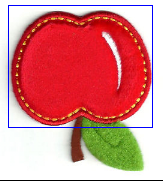

In [222]:
# quick sanity check

from PIL import ImageDraw, ImageFont

image, labels = train_data[42]

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')

image

### Задание 1.
Примените обученные детекторы из torchvision.models - Faster R-CNN, RetinaNet, SSD (можно только с одним backbone, можно все попробовать) - и оцените качество детекции на тестовом датасете.

In [26]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

def get_detection_model(num_classes, is_pretrained=True):
    model = fasterrcnn_resnet50_fpn(pretrained=is_pretrained)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [26]:
model = get_detection_model(num_classes=num_classes)
model.to(device)

mean_ap = evaluate(model, test_loader, device=device)
print(f"Pretrained Faster R-CNN mAP is {round(mean_ap, 3)}")  # quite low :(

Pretrained Faster R-CNN mAP is 0.04


### Задание 2.
Обучите детекторы из задания выше на обучающем датасете, оцените качество на тестовом. При необходимости, подберите гиперпараметры - optimizer, lr, weight_decay etc.
Выполните обучение в двух вариантах: со случайной инициализацией весов и с загрузкой весов уже обученной модели. Сравните качество.

### Setting up model, optimizer, scheduler and other stuff

In [30]:
# !mkdir model_checkpoints

In [1]:
model = get_detection_model(num_classes=num_classes)  # pretrained model
model.to(device)

In [226]:
torch.cuda.empty_cache()

In [224]:
model_params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(model_params, lr=5e-3, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1)

### Fine-tuning pretrained model

In [225]:
# best model checkpoints are saved
# model is saved when the script gets SIGINT
num_epochs = 10
train(model, num_epochs, train_loader, test_loader, optimizer, scheduler=lr_scheduler, device=device, best_model_name="best_model_pretrained")

Epoch [0/10] ...
Loss value after 10 batches is 0.6483937282272184
Loss value after 20 batches is 0.504907836320079
Loss value after 30 batches is 0.4286704120396424
Loss value after 40 batches is 0.41836182664788185
Loss value after 50 batches is 0.3892997754634829
Loss value after 60 batches is 0.3659766082114739
New best model, score: 0.7157663129029135
Epoch 0 done in 30.09s
Model mAP after epoch 0 is 0.716
Epoch [1/10] ...
Loss value after 10 batches is 0.24591299371623307
Loss value after 20 batches is 0.23365692722791304
Loss value after 30 batches is 0.2184071726924155
Loss value after 40 batches is 0.23819147135968347
Loss value after 50 batches is 0.24473341837049348
Loss value after 60 batches is 0.2591447247563274
New best model, score: 0.7979519894068883
Epoch 1 done in 30.28s
Model mAP after epoch 1 is 0.798
Epoch [2/10] ...
Loss value after 10 batches is 0.29525579780794053
Loss value after 20 batches is 0.27081804801234594
Loss value after 30 batches is 0.27774878068044

In [70]:
checkpoint = torch.load("model_checkpoints/best_model_pretrained_1c.pt")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [71]:
mean_ap = evaluate(model, test_loader, device)
print(f"mAP is {round(mean_ap, 2)}")  # PR-AUC / mAP is 0.92

mAP is 0.92


### Setting up optimizer, scheduler and other stuff

In [2]:
model = get_detection_model(num_classes=num_classes, is_pretrained=False)
model.to(device)

In [41]:
torch.cuda.empty_cache()

In [46]:
model_params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(model_params, lr=5e-3, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1)

In [43]:
# best model checkpoints are saved
# model is saved when the script gets SIGINT
num_epochs = 10
train(model, num_epochs, train_loader, test_loader, optimizer, scheduler=lr_scheduler, device=device, best_model_name="best_model_raw_1c")

Epoch [0/10] ...
Loss value after 10 batches is 1.0288920845253169
Loss value after 20 batches is 0.7282520529941084
Loss value after 30 batches is 0.5823921119090932
Loss value after 40 batches is 0.5546287039602676
Loss value after 50 batches is 0.4987377228039505
Loss value after 60 batches is 0.47682740428785075
New best model, score: 0.2112064206441369
Epoch 0 done in 29.38s
Model mAP after epoch 0 is 0.211
Epoch [1/10] ...
Loss value after 10 batches is 0.35397030519180783
Loss value after 20 batches is 0.33662458997998057
Loss value after 30 batches is 0.33613422379601715
Loss value after 40 batches is 0.33788810717064405
Loss value after 50 batches is 0.34837107008528173
Loss value after 60 batches is 0.3398912228863464
New best model, score: 0.4351299551731503
Epoch 1 done in 29.42s
Model mAP after epoch 1 is 0.435
Epoch [2/10] ...
Loss value after 10 batches is 0.3741700318631588
Loss value after 20 batches is 0.33855722943144906
Loss value after 30 batches is 0.3171784399466

In [44]:
checkpoint = torch.load("model_checkpoints/best_model_raw_1c.pt")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [45]:
mean_ap = evaluate(model, test_loader, device)
print(f"mAP is {mean_ap}")  # PR-AUC / mAP is 0.76, which is definitely worse than results of the pretrained model

mAP is 0.7591279634237438


### Задание 3.
- Для лучшей модели оцените, как меняется качество на тестовых данных при изменении порога IoU.  
- Также добавьте порог для минимального значения score у предсказанных bounding box'ов, таким образом отсеивая предсказания с низким конфиденсом. Оцените, как меняется качество при изменении порога (порог IoU используйте 0.5). 

In [ ]:
del model  # we'll free some precious CUDA memory

In [3]:
best_model = get_detection_model(num_classes=num_classes)  # pretrained model
best_model.to(device)

checkpoint = torch.load("model_checkpoints/best_model_pretrained.pt")
best_model.load_state_dict(checkpoint['model_state_dict'])

best_model.eval()

In [77]:
for iou in range(1, 10):
    print(f"mAP [IoU = {iou / 10}] is {evaluate(best_model, test_loader, device, iou_threshold=(iou / 10))}")
    
# recognition rate gets worse

mAP [IoU = 0.1] is 0.9435917003715698
mAP [IoU = 0.2] is 0.9370600605412276
mAP [IoU = 0.3] is 0.9333955718250709
mAP [IoU = 0.4] is 0.9282135342113252
mAP [IoU = 0.5] is 0.9162613894376384
mAP [IoU = 0.6] is 0.8707752342615013
mAP [IoU = 0.7] is 0.7205798825592746
mAP [IoU = 0.8] is 0.4399389604310923
mAP [IoU = 0.9] is 0.013010742517401598


In [236]:
image, labels = next(iter(test_data))
pred = best_model(image.unsqueeze(0).to(device))[0]

# I modified `evaluate_sample` and `evaluate` functions, adding there `confidence_threshold` and filtering by it
# let's look how it works

In [93]:
evaluate_sample(pred, labels, iou_threshold=0.5, confidence_threshold=0)  # look at the scores here that get TP[1]

[{'score': 0.9681438, 'TP': 1, 'max_IoU': 0.8511664510558835},
 {'score': 0.95729196, 'TP': 1, 'max_IoU': 0.8441311303929674},
 {'score': 0.9381555, 'TP': 1, 'max_IoU': 0.8028487090342536},
 {'score': 0.9087557, 'TP': 1, 'max_IoU': 0.8492036709445143},
 {'score': 0.90765184, 'TP': 1, 'max_IoU': 0.6709331038018603},
 {'score': 0.7953418, 'TP': 0},
 {'score': 0.4756027, 'TP': 0},
 {'score': 0.3375302, 'TP': 0},
 {'score': 0.31461605, 'TP': 0},
 {'score': 0.30277577, 'TP': 0},
 {'score': 0.30056047, 'TP': 0},
 {'score': 0.2743982, 'TP': 0},
 {'score': 0.22290272, 'TP': 0},
 {'score': 0.21905337, 'TP': 0},
 {'score': 0.17807992, 'TP': 0},
 {'score': 0.16712718, 'TP': 0},
 {'score': 0.12671027, 'TP': 0},
 {'score': 0.11325269, 'TP': 0},
 {'score': 0.10842003, 'TP': 0},
 {'score': 0.10745559, 'TP': 0},
 {'score': 0.102563195, 'TP': 0},
 {'score': 0.09620577, 'TP': 0},
 {'score': 0.09063305, 'TP': 0},
 {'score': 0.07293728, 'TP': 0},
 {'score': 0.057719722, 'TP': 0}]

In [94]:
evaluate_sample(pred, labels, iou_threshold=0.5, confidence_threshold=0.91)  # and here only scores >= 0.91 get TP[1], so it works perfectly fine!

[{'score': 0.9681438, 'TP': 1, 'max_IoU': 0.8511664510558835},
 {'score': 0.95729196, 'TP': 1, 'max_IoU': 0.8441311303929674},
 {'score': 0.9381555, 'TP': 1, 'max_IoU': 0.8028487090342536},
 {'score': 0.9087557, 'TP': 0},
 {'score': 0.90765184, 'TP': 0},
 {'score': 0.7953418, 'TP': 0},
 {'score': 0.4756027, 'TP': 0},
 {'score': 0.3375302, 'TP': 0},
 {'score': 0.31461605, 'TP': 0},
 {'score': 0.30277577, 'TP': 0},
 {'score': 0.30056047, 'TP': 0},
 {'score': 0.2743982, 'TP': 0},
 {'score': 0.22290272, 'TP': 0},
 {'score': 0.21905337, 'TP': 0},
 {'score': 0.17807992, 'TP': 0},
 {'score': 0.16712718, 'TP': 0},
 {'score': 0.12671027, 'TP': 0},
 {'score': 0.11325269, 'TP': 0},
 {'score': 0.10842003, 'TP': 0},
 {'score': 0.10745559, 'TP': 0},
 {'score': 0.102563195, 'TP': 0},
 {'score': 0.09620577, 'TP': 0},
 {'score': 0.09063305, 'TP': 0},
 {'score': 0.07293728, 'TP': 0},
 {'score': 0.057719722, 'TP': 0}]

In [101]:
for confidence in [0, 0.25, 0.5, 0.75, 0.9, 0.95]:
    mean_ap = evaluate(best_model, test_loader, device, confidence_threshold=confidence)
    print(f"mAP [confidence >= {confidence}] is {round(mean_ap, 2)}")
    
# recognition rate gets worse

mAP [confidence >= 0] is 0.92
mAP [confidence >= 0.25] is 0.91
mAP [confidence >= 0.5] is 0.9
mAP [confidence >= 0.75] is 0.85
mAP [confidence >= 0.9] is 0.73
mAP [confidence >= 0.95] is 0.53


### Задание 4.
Нарисуйте предсказанные bounding box'ы для любых двух картинок из тестового датасета и каких-нибудь картинок из интернета (релевантных - где есть эти фрукты - и тех, где этих фруктов нет).

In [103]:
tags = ["background", "fruit"]

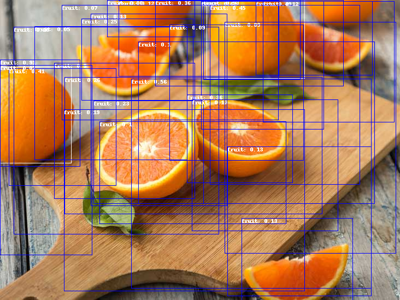

In [106]:
image, labels = test_data[42]
pred = best_model(image.unsqueeze(0).to(device))[0]

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box, label, score in zip(pred['boxes'], pred["labels"], pred["scores"]):
    score = round(float(score.cpu().detach().numpy()), 2)
    draw.text((box[0], box[1]), f"{tags[label]}: {str(score)}")
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')   
    
image.resize((400, 300))

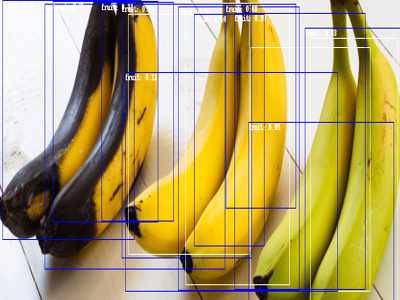

In [135]:
image, labels = test_data[29]
pred = best_model(image.unsqueeze(0).to(device))[0]

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box, label, score in zip(pred['boxes'], pred["labels"], pred["scores"]):
    score = round(float(score.cpu().detach().numpy()), 2)
    draw.text((box[0], box[1]), f"{tags[label]}: {str(score)}")
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')   
    
image.resize((400, 300))

In [123]:
# just awesome car :)
!wget "https://cdn.motor1.com/images/mgl/VA0z9/s3/tesla-roadster.jpg"

# and just a random banana
!wget "https://www.insidehook.com/wp-content/uploads/2021/07/hero-6.jpg"

--2021-12-20 02:10:54--  https://cdn.motor1.com/images/mgl/VA0z9/s3/tesla-roadster.jpg
Resolving cdn.motor1.com (cdn.motor1.com)... 143.204.55.97, 143.204.55.8, 143.204.55.25, ...
Connecting to cdn.motor1.com (cdn.motor1.com)|143.204.55.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73862 (72K) [image/jpeg]
Saving to: ‘tesla-roadster.jpg.1’

tesla-roadster.jpg. 100%[===================>]  72.13K  --.-KB/s    in 0.003s  

2021-12-20 02:10:54 (23.7 MB/s) - ‘tesla-roadster.jpg.1’ saved [73862/73862]

--2021-12-20 02:10:54--  https://www.insidehook.com/wp-content/uploads/2021/07/hero-6.jpg
Resolving www.insidehook.com (www.insidehook.com)... 192.0.66.2
Connecting to www.insidehook.com (www.insidehook.com)|192.0.66.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 544053 (531K) [image/jpeg]
Saving to: ‘hero-6.jpg’

hero-6.jpg          100%[===================>] 531.30K  --.-KB/s    in 0.1s    

2021-12-20 02:10:55 (3.69 MB/s) - ‘hero-6

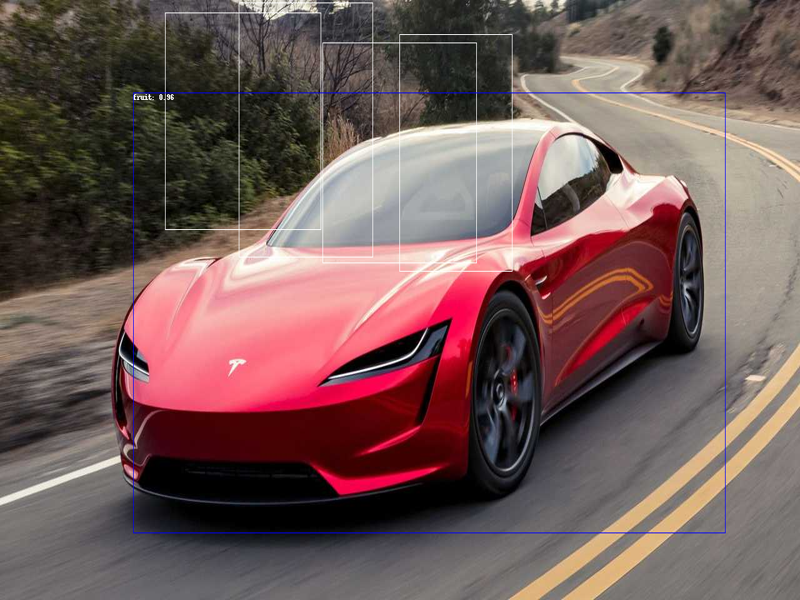

In [145]:
image = cv2.cvtColor(cv2.imread("tesla-roadster.jpg"), cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
image = torch.from_numpy(image)
image = image.permute(2, 0, 1)

pred = best_model(image.unsqueeze(0).to(device))[0]

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box, label, score in zip(pred['boxes'], pred["labels"], pred["scores"]):
    score = round(float(score.cpu().detach().numpy()), 2)
    if score >= 0.9:
        draw.text((box[0], box[1]), f"{tags[label]}: {str(score)}")
        draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')   
    
image.resize((800, 600))

# well, it found the car on this photo quite accurately buuuut...
# it's not really a fruit ;)
# but anyway, that's it

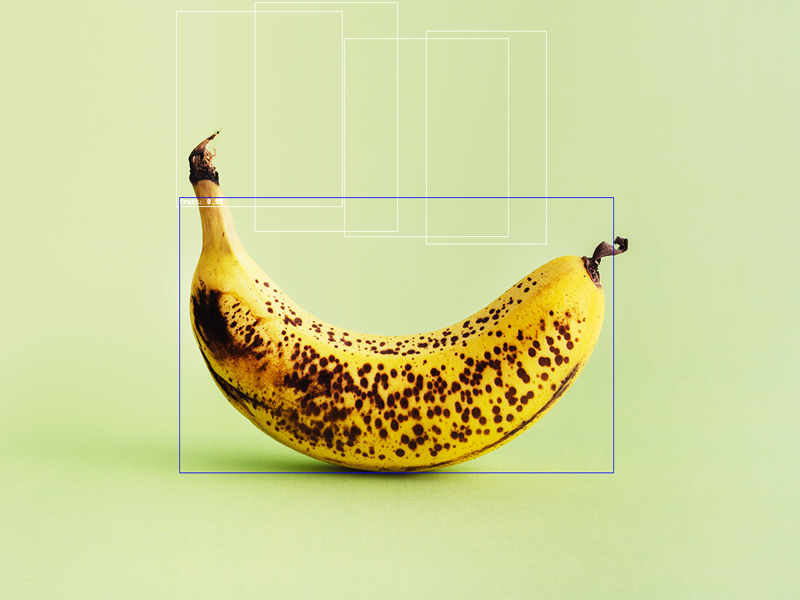

In [146]:
image = cv2.cvtColor(cv2.imread("hero-6.jpg"), cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
image = torch.from_numpy(image)
image = image.permute(2, 0, 1)

pred = best_model(image.unsqueeze(0).to(device))[0]

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box, label, score in zip(pred['boxes'], pred["labels"], pred["scores"]):
    score = round(float(score.cpu().detach().numpy()), 2)
    if score >= 0.9:
        draw.text((box[0], box[1]), f"{tags[label]}: {str(score)}")
        draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')   
    
image.resize((800, 600))

# well, yeah
# quite right i guess

### Задание 5.
Реализуйте и примените Non-maximum Suppression. Оцените (визуально и по метрикам), как его использование влияет на качество детекции.
NB: Чтобы продемонстрировать эффективность применения алгоритма, возможно, нужно будет взять достаточно низкий порог конфиденса.

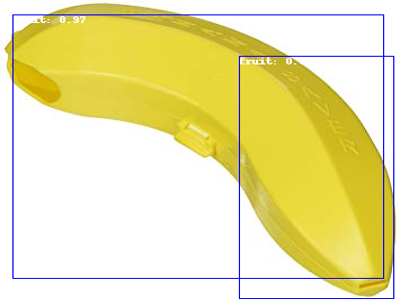

In [250]:
image, labels = test_data[36]
pred = best_model(image.unsqueeze(0).to(device))[0]

boxes, labels, scores = nms(pred["boxes"], pred["labels"], pred["scores"], 0.5)

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box, label, score in zip(boxes, labels, scores):
    score = round(float(score.cpu().detach().numpy()), 2)
    if score >= 0:
        draw.text((box[0], box[1]), f"{tags[label]}: {str(score)}")
        draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')
    
image.resize((400, 300))

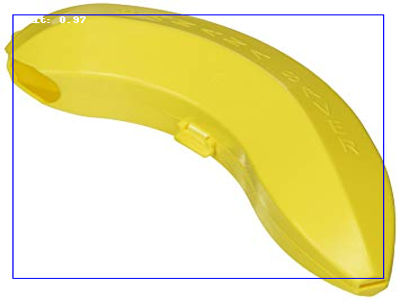

In [251]:
image, labels = test_data[36]
pred = best_model(image.unsqueeze(0).to(device))[0]

boxes, labels, scores = nms(pred["boxes"], pred["labels"], pred["scores"], 0.5)

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box, label, score in zip(boxes, labels, scores):
    score = round(float(score.cpu().detach().numpy()), 2)
    if score >= 0.4:
        draw.text((box[0], box[1]), f"{tags[label]}: {str(score)}")
        draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')
    
image.resize((400, 300))

# NMS is implemented in the beginning of this notebook
# `evaluate_sample` and `evaluate` were slightly modified to support NMS
# NMS definitely works here and show good results
# regarding the metrics, our model recognizes less boxes, but does that more accurately

<br>  
<br>  
  
## Часть 2.  
  
*Вес в общей оценке - 0.4*  
  
Выполните задания 2-5 из предыдущей части для случая 3-х классов (как в изначальном датасете).

### Data preparation

In [270]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
num_classes = 4 # background [0] and 3 kinds of fruits [1 - 3]

In [253]:
batch_size = 4
class2tag = {"apple": 1, "orange": 2, "banana": 3}

In [254]:
train_data = FruitDataset(
    data_dir="data/train_zip/train", 
    transform=get_transforms(train=True),
    class2tag=class2tag
    )

test_data = FruitDataset(
    data_dir="data/test_zip/test", 
    transform=get_transforms(train=False),
    class2tag=class2tag
    )

In [255]:
train_loader = DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4, 
    collate_fn=collate_fn
    )

test_loader = DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=4,
    collate_fn=collate_fn
    )

### Задание 2.
Обучите детекторы на обучающем датасете, оцените качество на тестовом. При необходимости, подберите гиперпараметры - optimizer, lr, weight_decay etc.
Выполните обучение в двух вариантах: со случайной инициализацией весов и с загрузкой весов уже обученной модели. Сравните качество.

In [256]:
torch.cuda.empty_cache()

In [4]:
model = get_detection_model(num_classes=num_classes)  # pretrained model
model.to(device)

In [258]:
torch.cuda.empty_cache()

In [261]:
model_params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(model_params, lr=2e-3, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=3)

### Fine-tuning pretrained model

In [262]:
# best model checkpoints are saved
# model is saved when the script gets SIGINT
num_epochs = 15
train(model, num_epochs, train_loader, test_loader, optimizer, scheduler=lr_scheduler, device=device, best_model_name="best_model_pretrained_3c")

Epoch [0/15] ...
Loss value after 10 batches is 0.7473540608428738
Loss value after 20 batches is 0.6437994233875661
Loss value after 30 batches is 0.5939100443331354
Loss value after 40 batches is 0.5523332364489253
Loss value after 50 batches is 0.5407298414272453
Loss value after 60 batches is 0.5098603421123
New best model, score: 0.550040604634785
Epoch 0 done in 29.97s
Model mAP after epoch 0 is 0.55
Epoch [1/15] ...
Loss value after 10 batches is 0.3109334881259714
Loss value after 20 batches is 0.3349457875818518
Loss value after 30 batches is 0.354919102549
Loss value after 40 batches is 0.3593396638127687
Loss value after 50 batches is 0.3581623301562177
Loss value after 60 batches is 0.369489939460221
New best model, score: 0.7233722655809084
Epoch 1 done in 30.65s
Model mAP after epoch 1 is 0.723
Epoch [2/15] ...
Loss value after 10 batches is 0.3252048654918829
Loss value after 20 batches is 0.31998647220970317
Loss value after 30 batches is 0.31265984369700917
Loss value 

In [263]:
checkpoint = torch.load("model_checkpoints/best_model_pretrained.pt")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [264]:
mean_ap = evaluate(model, test_loader, device)
print(f"mAP is {round(mean_ap, 2)}")  # PR-AUC / mAP is 0.89 for 3 classes

mAP is 0.89


### Setting up optimizer, scheduler and other stuff

In [6]:
model = get_detection_model(num_classes=num_classes, is_pretrained=False)
model.to(device)

In [266]:
torch.cuda.empty_cache()

In [267]:
model_params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(model_params, lr=2e-3, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1)

In [268]:
# best model checkpoints are saved
# model is saved when the script gets SIGINT
num_epochs = 15
train(model, num_epochs, train_loader, test_loader, optimizer, scheduler=lr_scheduler, device=device, best_model_name="best_model_raw_3c")

Epoch [0/15] ...
Loss value after 10 batches is 1.4655663653349624
Loss value after 20 batches is 0.9720544768483388
Loss value after 30 batches is 0.7938716695381107
Loss value after 40 batches is 0.6922450775850276
Loss value after 50 batches is 0.6297094443367431
Loss value after 60 batches is 0.5973502501071856
New best model, score: 0.043341484117923074
Epoch 0 done in 30.94s
Model mAP after epoch 0 is 0.043
Epoch [1/15] ...
Loss value after 10 batches is 0.44345633988147687
Loss value after 20 batches is 0.3891097739570183
Loss value after 30 batches is 0.4087464148090601
Loss value after 40 batches is 0.41232280761041834
Loss value after 50 batches is 0.40187637584358527
Loss value after 60 batches is 0.39491749442922336
New best model, score: 0.12686551434286145
Epoch 1 done in 30.78s
Model mAP after epoch 1 is 0.127
Epoch [2/15] ...
Loss value after 10 batches is 0.3497431422289801
Loss value after 20 batches is 0.3306569317653052
Loss value after 30 batches is 0.3318156434135

In [271]:
checkpoint = torch.load("model_checkpoints/best_model_raw_3c.pt")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [272]:
mean_ap = evaluate(model, test_loader, device)
print(f"mAP is {round(mean_ap, 2)}")  # PR-AUC / mAP is 0.712, which is definitely worse than results of the pretrained model

mAP is 0.7119843214333075


### Задание 3.
- Для лучшей модели оцените, как меняется качество на тестовых данных при изменении порога IoU.  
- Также добавьте порог для минимального значения score у предсказанных bounding box'ов, таким образом отсеивая предсказания с низким конфиденсом. Оцените, как меняется качество при изменении порога (порог IoU используйте 0.5). 

In [ ]:
del model  # we'll free some precious CUDA memory

In [5]:
best_model = get_detection_model(num_classes=num_classes)  # pretrained model
best_model.to(device)

checkpoint = torch.load("model_checkpoints/best_model_pretrained_3c.pt")
best_model.load_state_dict(checkpoint['model_state_dict'])

best_model.eval()

In [274]:
for iou in range(1, 10):
    print(f"mAP [IoU = {iou / 10}] is {evaluate(best_model, test_loader, device, iou_threshold=(iou / 10))}")
    
# recognition rate gets worse

mAP [IoU = 0.1] is 0.9386789376449748
mAP [IoU = 0.2] is 0.9239683226707026
mAP [IoU = 0.3] is 0.9104855161053051
mAP [IoU = 0.4] is 0.8957703202039996
mAP [IoU = 0.5] is 0.8894200898608877
mAP [IoU = 0.6] is 0.845562104369787
mAP [IoU = 0.7] is 0.696958198315372
mAP [IoU = 0.8] is 0.34914903774527706
mAP [IoU = 0.9] is 0.027387967372792033


In [275]:
image, labels = next(iter(test_data))
pred = best_model(image.unsqueeze(0).to(device))[0]

# I modified `evaluate_sample` and `evaluate` functions, adding there `confidence_threshold` and filtering by it
# let's look how it works

In [277]:
evaluate_sample(pred, labels, iou_threshold=0.5, confidence_threshold=0, nms=False)  # look at the scores here that get TP[1]

[{'score': 0.9385559, 'TP': 1, 'max_IoU': 0.9481827580384721},
 {'score': 0.91501635, 'TP': 1, 'max_IoU': 0.9133399855658234},
 {'score': 0.8519289, 'TP': 0},
 {'score': 0.8324391, 'TP': 1, 'max_IoU': 0.6782029212359054},
 {'score': 0.8239736, 'TP': 1, 'max_IoU': 0.8061370629124506},
 {'score': 0.78765637, 'TP': 1, 'max_IoU': 0.9343253935353623},
 {'score': 0.68181443, 'TP': 0},
 {'score': 0.49755913, 'TP': 0},
 {'score': 0.43007234, 'TP': 0},
 {'score': 0.4245216, 'TP': 0},
 {'score': 0.32713258, 'TP': 0},
 {'score': 0.20606236, 'TP': 0},
 {'score': 0.19034675, 'TP': 0},
 {'score': 0.18665117, 'TP': 0},
 {'score': 0.15716504, 'TP': 0},
 {'score': 0.116097614, 'TP': 0},
 {'score': 0.097033106, 'TP': 0},
 {'score': 0.06972836, 'TP': 0}]

In [278]:
evaluate_sample(pred, labels, iou_threshold=0.5, confidence_threshold=0.91, nms=False)  # and here only scores >= 0.91 get TP[1], so it works perfectly fine!

[{'score': 0.9385559, 'TP': 1, 'max_IoU': 0.9481827580384721},
 {'score': 0.91501635, 'TP': 1, 'max_IoU': 0.9133399855658234},
 {'score': 0.8519289, 'TP': 0},
 {'score': 0.8324391, 'TP': 0},
 {'score': 0.8239736, 'TP': 0},
 {'score': 0.78765637, 'TP': 0},
 {'score': 0.68181443, 'TP': 0},
 {'score': 0.49755913, 'TP': 0},
 {'score': 0.43007234, 'TP': 0},
 {'score': 0.4245216, 'TP': 0},
 {'score': 0.32713258, 'TP': 0},
 {'score': 0.20606236, 'TP': 0},
 {'score': 0.19034675, 'TP': 0},
 {'score': 0.18665117, 'TP': 0},
 {'score': 0.15716504, 'TP': 0},
 {'score': 0.116097614, 'TP': 0},
 {'score': 0.097033106, 'TP': 0},
 {'score': 0.06972836, 'TP': 0}]

In [279]:
for confidence in [0, 0.25, 0.5, 0.75, 0.9, 0.95]:
    mean_ap = evaluate(best_model, test_loader, device, confidence_threshold=confidence)
    print(f"mAP [confidence >= {confidence}] is {round(mean_ap, 2)}")
    
# recognition rate gets worse

mAP [confidence >= 0] is 0.89
mAP [confidence >= 0.25] is 0.88
mAP [confidence >= 0.5] is 0.84
mAP [confidence >= 0.75] is 0.79
mAP [confidence >= 0.9] is 0.59
mAP [confidence >= 0.95] is 0.44


### Задание 4.
Нарисуйте предсказанные bounding box'ы для любых двух картинок из тестового датасета и каких-нибудь картинок из интернета (релевантных - где есть эти фрукты - и тех, где этих фруктов нет).

In [284]:
tags = ["background", "apple", "orange", "banana"]

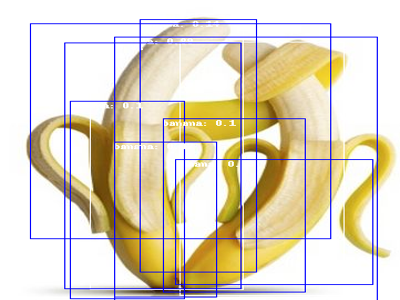

In [290]:
image, labels = test_data[20]
pred = best_model(image.unsqueeze(0).to(device))[0]

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box, label, score in zip(pred['boxes'], pred["labels"], pred["scores"]):
    score = round(float(score.cpu().detach().numpy()), 2)
    draw.text((box[0], box[1]), f"{tags[label]}: {str(score)}")
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')   
    
image.resize((400, 300))

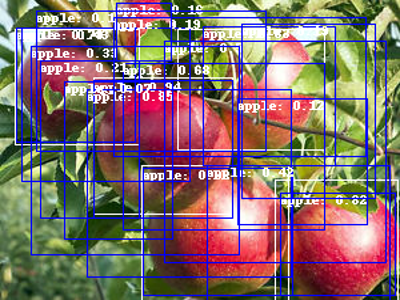

In [291]:
image, labels = test_data[0]
pred = best_model(image.unsqueeze(0).to(device))[0]

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box, label, score in zip(pred['boxes'], pred["labels"], pred["scores"]):
    score = round(float(score.cpu().detach().numpy()), 2)
    draw.text((box[0], box[1]), f"{tags[label]}: {str(score)}")
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')   
    
image.resize((400, 300))

In [293]:
# just awesome car :)
# !wget "https://cdn.motor1.com/images/mgl/VA0z9/s3/tesla-roadster.jpg"

# and just a random banana
# !wget "https://www.insidehook.com/wp-content/uploads/2021/07/hero-6.jpg"

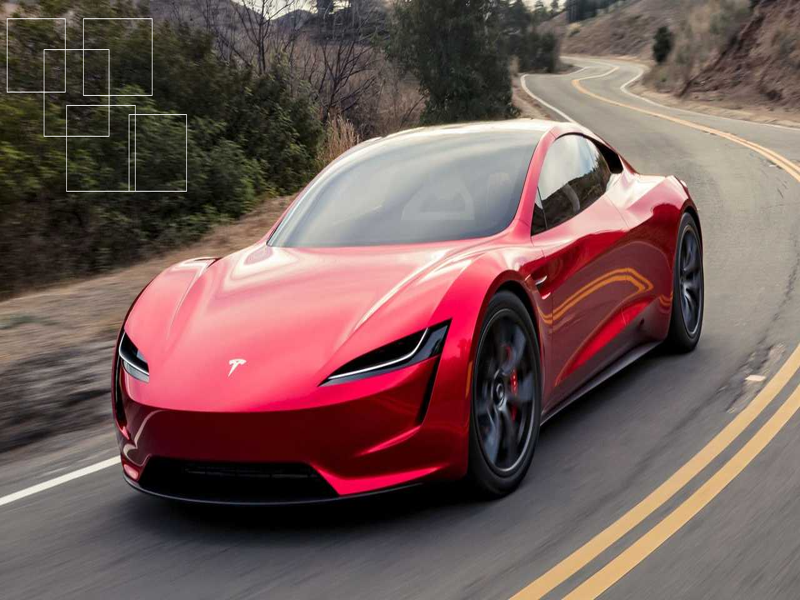

In [294]:
image = cv2.cvtColor(cv2.imread("tesla-roadster.jpg"), cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
image = torch.from_numpy(image)
image = image.permute(2, 0, 1)

pred = best_model(image.unsqueeze(0).to(device))[0]

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box, label, score in zip(pred['boxes'], pred["labels"], pred["scores"]):
    score = round(float(score.cpu().detach().numpy()), 2)
    if score >= 0.9:
        draw.text((box[0], box[1]), f"{tags[label]}: {str(score)}")
        draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')   
    
image.resize((800, 600))

# well, it works!

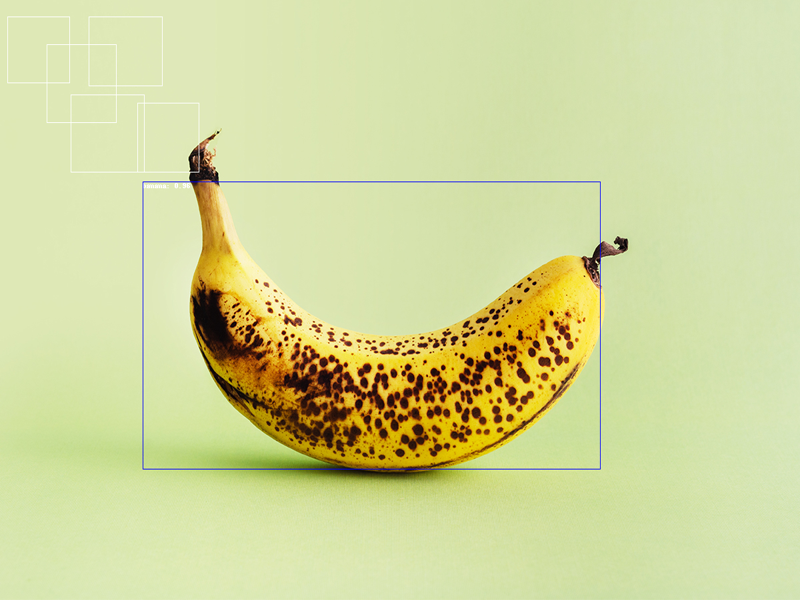

In [295]:
image = cv2.cvtColor(cv2.imread("hero-6.jpg"), cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
image = torch.from_numpy(image)
image = image.permute(2, 0, 1)

pred = best_model(image.unsqueeze(0).to(device))[0]

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box, label, score in zip(pred['boxes'], pred["labels"], pred["scores"]):
    score = round(float(score.cpu().detach().numpy()), 2)
    if score >= 0.9:
        draw.text((box[0], box[1]), f"{tags[label]}: {str(score)}")
        draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')   
    
image.resize((800, 600))

# awesome! it detected banana right!

### Задание 5.
Реализуйте и примените Non-maximum Suppression. Оцените (визуально и по метрикам), как его использование влияет на качество детекции.
NB: Чтобы продемонстрировать эффективность применения алгоритма, возможно, нужно будет взять достаточно низкий порог конфиденса.

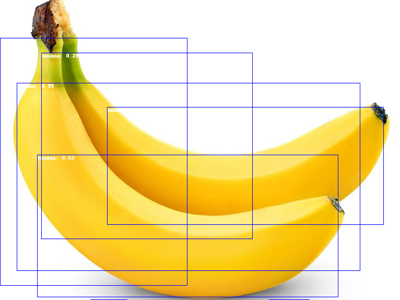

In [340]:
image, labels = test_data[23]
pred = best_model(image.unsqueeze(0).to(device))[0]

boxes, labels, scores = pred["boxes"], pred["labels"], pred["scores"]

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box, label, score in zip(boxes, labels, scores):
    score = round(float(score.cpu().detach().numpy()), 2)
    if score >= 0:
        draw.text((box[0], box[1]), f"{tags[label]}: {str(score)}")
        draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')
    
image.resize((400, 300))

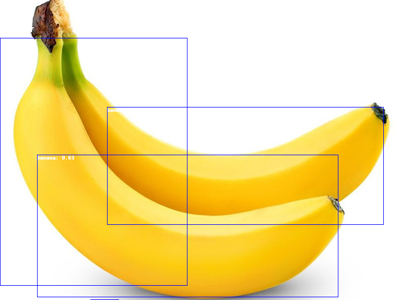

In [342]:
image, labels = test_data[23]
pred = best_model(image.unsqueeze(0).to(device))[0]

boxes, labels, scores = nms(pred["boxes"], pred["labels"], pred["scores"], 0.5)

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box, label, score in zip(boxes, labels, scores):
    score = round(float(score.cpu().detach().numpy()), 2)
    if score >= 0.2:
        draw.text((box[0], box[1]), f"{tags[label]}: {str(score)}")
        draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')

image.resize((400, 300))

# NMS is implemented in the beginning of this notebook
# `evaluate_sample` and `evaluate` were slightly modified to support NMS
# NMS definitely works here and shows good results
# regarding the metrics, our model recognizes less boxes, but does that more accurately

In [303]:
mean_ap = evaluate(best_model, test_loader, device, nms=False)
print(f"mAP is {round(mean_ap, 2)}")

mAP is 0.89


In [304]:
# mean_ap = evaluate(best_model, test_loader, device, confidence=0.4, nms=True)
mean_ap = evaluate(best_model, test_loader, device, nms=True)
print(f"mAP is {round(mean_ap, 2)}")

mAP is 0.26


## Часть 3.

#### Best 3-class model results – **0.89**

In [345]:
round(min(2, 2 * 0.89 / 0.91), 2)
# maybe we should just round this up to 2 points so i get 10.0? ;)

1.96